# Exercise 5 - Image classification with Feature Maps

In this exercise you will learn how feature maps can be used improve the accuracy of image classifiers based on softmax regression.

In the event of a persistent problem, do not hesitate to contact the course instructor under

- paul.kahlmeyer@uni-jena.de
- maurice.wenig@uni-jena.de

### Submission
- Deadline of submission:
21.05.2024 23:59
- Submission on [moodle page](https://moodle.uni-jena.de/course/view.php?id=54249)

## Softmax Regression

In this classification task we have more than two classes, therefore we use *softmax regression* as the natural extension of logistic regression (see exercise 2).

Recall, that in softmax regression we have features $x\in\mathbb{R}^n$ which we want to classify into $k$ classes.
The goal is then to find a matrix $\theta\in\mathbb{R}^{n\times k}$, so that

\begin{equation}
p(y=i|x) = \cfrac{\exp\left(x^T\theta^{(i)}\right)}{\sum_{j=1}^{k}\exp\left(x^T\theta^{(j)}\right)}
\end{equation}

where $\theta^{(i)}$ is the i-th column of $\theta$.

## Dataset

For this exercise we use a preprocessed subset of a dataset for [Scene Classification](https://www.kaggle.com/nitishabharathi/scene-classification). All images are 64x64 grayscale images from one of three classes:
- Buildings
- Forest
- Mountains

The goal of this exercise is to train classifiers that can classify images into their respective scenery.

### Task 1

The dataset is stored as numpy arrays under `X.npy` (images) and `Y.npy` (labels).

Load the dataset and display an image per class using matplotlib. You need to reshape X to the right dimensions again, to show the proper image.

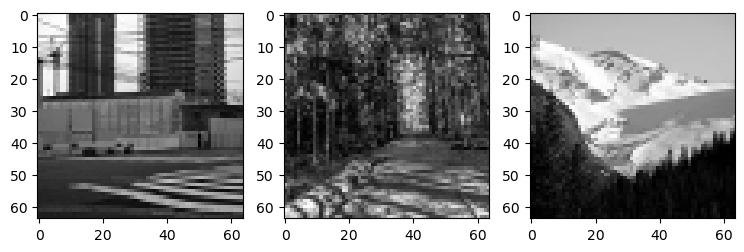

In [9]:
import numpy as np
import matplotlib.pyplot as plt

images = np.load('X.npy')
labels = np.load('Y.npy')

numClasses = 3
hight, width = 64, 64
fSize = 3
fig, axs = plt.subplots(nrows=1, ncols=numClasses, figsize=(3*fSize,fSize))

# TODO: Load dataset and display images
for i in range(numClasses):
    X = images[labels==i]
    randNum = np.random.randint(X.shape[0])
    image = X[randNum]
    axs[i].imshow(image.reshape((hight,width)), cmap='gray')

# assertions
assert images.shape == (3000, 4096)
assert labels.shape == (3000,)

# No feature map

A first approach for Softmax Regression would be to take the raw pixels as features.

### Task 2

In scikit-learn, softmax regression is implemented within the [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) class. 

Use scikit learn to fit softmax regression on the images and evaluate the accuracy on train (75%)- and test (25%) data.
What do you observe?

Hint: 
- Use the keyword "multinomial"
- Ignore the max_it warning and that it didn't converge you will see the accuracy on the training set is already pretty high and we cannot expect the accuracy on the test set to get much higher. This is also true for the remaining Tasks

In [10]:
# TODO: Split data into train and test data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.25, random_state=0)

assert len(train_images) // len(test_images) == 3
assert len(train_labels) // len(test_labels) == 3

# TODO: fit softmax regression
regressor = LogisticRegression(multi_class="multinomial", max_iter=1000, random_state=0)
regressor.fit(train_images,train_labels)

# TODO: get accuracy on train- and test data
accuracy_train = np.mean(regressor.predict(train_images) == train_labels)
accuracy_test = np.mean(regressor.predict(test_images) == test_labels)

# assertions
assert accuracy_train > 0.8
assert accuracy_test > 0.4

/usr/lib/python3/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Normalization

You probably observed, that softmax regression on the raw pixel values does not lead to good results. While the training accuracy is quite high, the test accuracy is very low.

One reason for this is that pixel values are *unnormalized*. This means, that different features (pixels) have different ranges and statistical properties.

When we use a regressor, we heavily rely on the dot product between two vectors as distance measure.

Recall, that for two vectors $x^{(1)}, x^{(2)}\in\mathbb{R}^d$ the dot product is defined as

\begin{align}
(x^{(1)})^\top x^{(2)} = \sum_{i=1}^d x^{(1)}_ix^{(2)}_i
\end{align}

In this distance measure, products over different features are added together. If we dont want certain features to dominate others, we have to normalize the features.

### Task 3

Visualize the mean values and the standard deviation for each feature (Pixel). What do you observe?

Hint:
- Reshape the values into image dimensions again

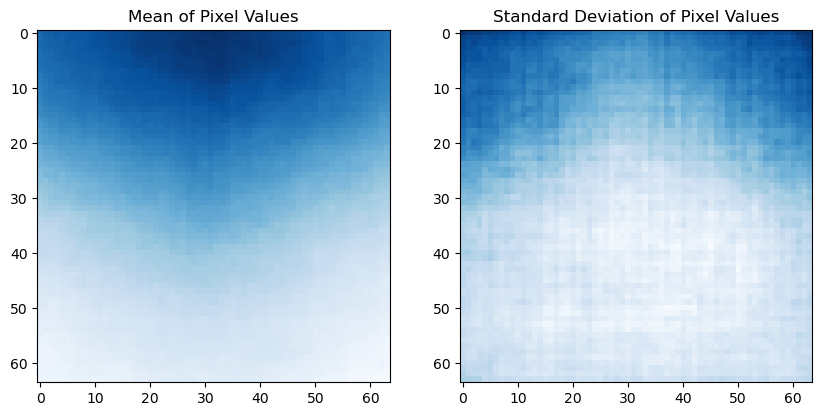

In [11]:
# TODO: Visualize mean and variance of pixel features
pixel_mean = np.mean(train_images, axis=0)
pixel_std = np.std(train_images, axis=0)


mean_image = pixel_mean.reshape(64, 64)
std_image = pixel_std.reshape(64, 64)

# assertions
#assert np.allclose(pixel_mean[:10], [130.10333333, 132.23633333, 132.76966667, 133.441, 133.01333333, 133.60533333, 134.254, 134.15466667, 134.16566667, 135.429])
#assert np.allclose(pixel_std[:10], [70.24772824, 69.51032882, 69.48432878, 69.35291764, 69.06238597, 69.00247994, 68.89604355, 68.59199719, 68.67530527, 67.87123317])

# Visualization
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].imshow(mean_image, cmap='Blues')
axs[0].set_title('Mean of Pixel Values')

axs[1].imshow(std_image, cmap='Blues')
axs[1].set_title('Standard Deviation of Pixel Values')

plt.show()

### Task 4

Normalize the dataset, so that each feature has mean 0 and standard deviation 1.
Similar to task 4, visualize the mean and variance values for the features of the normalized data.

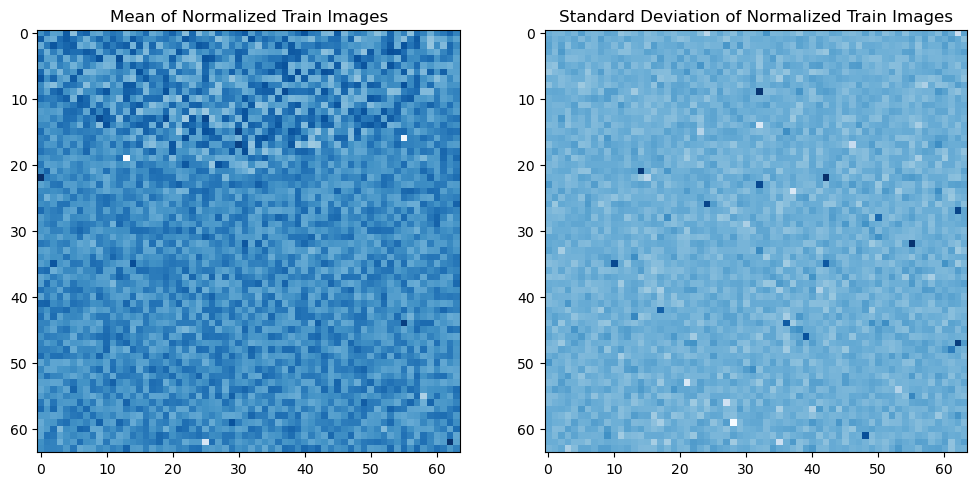

In [12]:
import numpy.typing as npt


def transform_normalize(x: npt.NDArray[np.uint8], mean: npt.NDArray[np.float64], std: npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
    """Normalizes the dataset.

    Parameters
    ----------
    x : npt.NDArray[np.uint8]
        Dataset (n x d).

    mean: npt.NDArray[np.float64]
        Feature mean (d).

    std: npt.NDArray[np.float64]
        Feature standard deviation (d).

    Returns
    -------
    npt.NDArray[np.float64]
        Normalized dataset such that each feature has mean = 0 and standard deviation = 1 (n x d).
    """

    # TODO: implement normalization
    return (x - mean) / std


# TODO: use your estimated mean and standard deviation to normalize the train and test images
train_images_normalized = transform_normalize(train_images, pixel_mean,pixel_std)
test_images_normalized =  transform_normalize(test_images, pixel_mean, pixel_std)

# TODO: visualize mean and variance of normalized pixel features

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

normalized_mean_train = np.mean(train_images_normalized, axis=0)
normalized_std_train = np.std(train_images_normalized, axis=0)

mean_image_normalized = normalized_mean_train.reshape(64, 64)
axs[0].imshow(mean_image_normalized, cmap='Blues')
axs[0].set_title('Mean of Normalized Train Images')

std_image_normalized = normalized_std_train.reshape(64, 64)
axs[1].imshow(std_image_normalized, cmap='Blues')
axs[1].set_title('Standard Deviation of Normalized Train Images')

plt.show()

### Task 5
Now use logistic regression on the transformed features. Calculate the accuracies on the train- and testset.

In [13]:
# TODO: use logistic regression on normalized features
regressor.fit(train_images_normalized, train_labels)
accuracy_train = np.mean(regressor.predict(train_images_normalized) == train_labels)
accuracy_test = np.mean(regressor.predict(test_images_normalized) == test_labels) 

# assertions
assert accuracy_train > 0.99
assert accuracy_test > 0.5

# Handcrafted features

**Feature maps** attempt to bypass this inconsistency by transforming the pixel vector into a different, more consistent feature vector. 

Especially in the field of image classification, a lot of attempts were made to derive features from images trough a pipeline of preprocessing.

We want to use edges in our images as features.
Edges are visual boundaries of objects. Hence they contain information about objects in images.
In grayscale images, we can interpret edges as sudden changes of pixel intensities in some direction.

## Convolution
In order to detect these changes, we will use linear filters on the images. A linear filter is determined by a kernel matrix $K$, that describes how a new pixel is created by a linear combination of its neighbouring pixels.

As an example, consider the following [kernel](https://en.wikipedia.org/wiki/Kernel_(image_processing)) matrix:

\begin{align}
K=\begin{bmatrix}
\frac{1}{9}&\frac{1}{9}&\frac{1}{9}\\
\frac{1}{9}&\frac{1}{9}&\frac{1}{9}\\
\frac{1}{9}&\frac{1}{9}&\frac{1}{9}
\end{bmatrix}\end{align}

For the calculation of a new pixel, we take the $3\times3$ neighbourhood, i.e. the 8 pixels around the original pixel and the pixel itself, multiply each of these pixels with its corresponding entry in $K$ and sum everything up. The example kernel will simply set a pixel to the average of its neighbouring pixels and is called *average filter*. We consider only kernels with *odd dimensions*.

For the pixels at the border of the image, there is no full neighbourhood and we will assume those missing pixels to be 0. Numpy has the [pad](https://numpy.org/doc/stable/reference/generated/numpy.pad.html) function, that takes an array and `pad_width` and by default adds `pad_width` zeros on each side of the array. Since numpy 1.20 there is another useful function for this task: [sliding_window_view](https://numpy.org/devdocs/reference/generated/numpy.lib.stride_tricks.sliding_window_view.html) takes an array and a window size (the kernel size for us) and returns a view (thus it doesn't copy the data) that has two new dimensions with the same size as the given kernel size. It's first two dimensions are a bit smaller since it always takes a full window and does not use the border pixels. If you combine pad with the sliding window you can create an array that has the correct neighbourhood at i,j which is a matrix with the same size as the kernel:
`sliding_window_view(padded_array,kernel.shape)[i,j] =  neighbourhood[i,j]`.

Finally this can be combined with [einsum](https://numpy.org/doc/stable/reference/generated/numpy.einsum.html) to create a fast convolution. For an introduction you can have a look at this [blog post](https://ajcr.net/Basic-guide-to-einsum/). To get the right explicit subscripts string, you need to think about the following questions:
1. How many dimensions / indices does each array have?
2. Which of those should get the same name? Remember that indices can only have the same name if they have the same dimension. By this limitation alone its often clear which indices should be repeated on the left side of the '->'.
3. How many dimensions should the result have and which of the indices should be in it? Remember you will sum over all indices missing in the result. This will give you the right side of the '->'.

If you can't get einsum to work, please reach out or just use several for loops as indicated in the linked wikipedia article. That will be quite slow however.

### Task 6
Implement a function, that performs convolution on an image with a given kernel. Consider neighbourhood values that are not within the image as zero (zero padding). Filter the third image from the dataset with the average filter from the example and display the result using matplotlib.

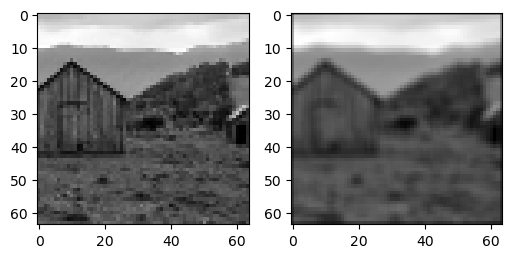

In [14]:
from numpy.lib.stride_tricks import sliding_window_view


def convolute(image: npt.NDArray[np.float64], kernel: npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
    """Convolutes an image with a kernel.

    Parameters
    ----------
    image : npt.NDArray[np.float64]
        Grayscale image matrix (h x w).
    kernel : npt.NDArray[np.float64]
        Kernel matrix (k x k).

    Returns
    -------
    npt.NDArray[np.float64]
        Convoluted image (h x w).
    """

    # TODO: Implement convolution function
    pad_size = tuple(x//2 for x in kernel.shape)
    view = sliding_window_view(np.pad(image, pad_size), kernel.shape)
    return np.einsum('kl,ijkl->ij',kernel,view)


# TODO: perform average filtering on image
kernel = np.ones((3,3))/9
image = images[2].reshape((hight, width))
convoluted_image = convolute(image, kernel)

# assertions
assert convoluted_image.shape == image.shape

# TODO: visualize the image and the result of the convolution
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(2*fSize, fSize))
axs[0].imshow(image, cmap='gray')
axs[1].imshow(convoluted_image, cmap='gray')

As mentioned before, edges correspond to a sudden change of the pixel intensities. 
We can detect these changes in horizontal and vertical direction with the kernel matrices

$\begin{aligned}
K_x = \begin{bmatrix}
-1&0&1\\
-2&0&2\\
-1&0&1
\end{bmatrix}\end{aligned} 
\begin{aligned}K_y = \begin{bmatrix}
-1&-2&-1\\
0&0&0\\
1&2&1
\end{bmatrix}\end{aligned}$

These kernel matrices are called *Sobel Filters* and serve as an approximation to the gradient of the pixel values.
Let $I_x$ and $I_y$ be the images obtained by filtering our original image with $K_x$ and $K_y$ respectively.

The magnitude of our gradient in both directions can be calculated by 

\begin{align}
|G| = \sqrt{I_x^2+I_y^2}
\end{align}


### Task 7

Implement a function that calculates the gradient image for a given image. Test this function and visualize an example for a gradient image.

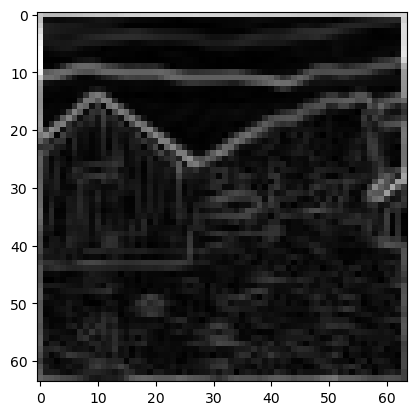

In [15]:
SOBEL_X = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1],
])
SOBEL_Y = np.array([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]
])


def image_gradient(image: npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
    """Calculates the magnitude of the image gradient.

    Parameters
    ----------
    image : npt.NDArray[np.float64]
        Grayscale image (h x w).

    Returns
    -------
    npt.NDArray[np.float64]
        Image with magnitude of image gradient (h x w).
    """

    # TODO: implement
    Ix = convolute(image, SOBEL_X)
    Iy = convolute(image, SOBEL_Y)
    
    return np.sqrt(Ix**2 + Iy**2)

# TODO: calculate + display gradient image
image = images[2].reshape((hight, width))
gradient_image = image_gradient(image)
plt.imshow(gradient_image, cmap='gray')

### Task 8

Now we want to use this function to create a transformed dataset. Implement a function that takes a dataset of images and transforms it into a dataset of gradient images. Apply this function to the train- and testset.

Note: This might take a while. Have a look at the python package [tqdm](https://tqdm.github.io/) to visualize the conversion process.

In [21]:
from tqdm.notebook import tqdm

def transform_gradient(images: npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
    """Transforms a dataset into gradient image vectors.

    Parameters
    ----------
    images : npt.NDArray[np.float64]
        Image dataset (n x h x w).

    Returns
    -------
    npt.NDArray[np.float64]
        Dataset of gradient image vectors (n x h x w).
    """

    # TODO: transform dataset into gradient image vectors
    res = []
    for image in tqdm(images):
        gradient_image = image_gradient(image)  # Compute gradient
        res.append(gradient_image.flatten())
    return np.stack(res)

# TODO: transform train- and testset
train_images_gradient = transform_gradient(train_images)
test_images_gradient = transform_gradient(test_images)

Widget Javascript not detected.  It may not be installed or enabled properly. Reconnecting the current kernel may help.


Exception ignored in: <function tqdm.__del__ at 0x7ffab15e62a0>
Traceback (most recent call last):
  File "/usr/lib/python3/dist-packages/tqdm/std.py", line 1162, in __del__
    self.close()
  File "/usr/lib/python3/dist-packages/tqdm/notebook.py", line 288, in close
    self.disp(bar_style='danger', check_delay=False)
  File "/usr/lib/python3/dist-packages/tqdm/notebook.py", line 160, in display
    d = self.format_dict
        ^^^^^^^^^^^^^^^^
  File "/usr/lib/python3/dist-packages/tqdm/std.py", line 1476, in format_dict
    'colour': self.colour}
              ^^^^^^^^^^^
  File "/usr/lib/python3/dist-packages/tqdm/notebook.py", line 204, in colour
    return self.container.children[-2].style.bar_color
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'FloatProgress' object has no attribute 'style'


AttributeError: 'FloatProgress' object has no attribute 'style'

### Task 9
Now use logistic regression on the transformed trainset. What are the accuracies on the train- and testset?

In [22]:
# TODO: apply logistic regression on transformed train- and testset
regressor.fit(train_images_gradient, train_labels)
accuracy_train = np.mean(regressor.predict(train_images_gradient) == train_labels)
accuracy_test = np.mean(regressor.predict(test_images_gradient) == test_labels)

assert accuracy_train > 0.99
assert accuracy_test > 0.5

NameError: name 'train_images_gradient' is not defined

# Deep Learning Features

In practice, Deep Learning features are the state of the art for most image classification tasks.

Deep Learning features are obtained by processing an input feature with a trained *deep neural network*.
Such a neural network consists of multiple processing steps (*layers*) that are applied sequentially to the input feature.
The resulting features can be used for multiple tasks, such as classification using softmax regression.

We will not cover the topic of deep learning here, we rather view neural nets as a blackbox that works as a feature map.

## Pytorch

We will use a pretrained deep neural network from the deep learning library [Pytorch](https://pytorch.org/).

[Install Pytorch](https://pytorch.org/get-started/locally/) and run the imports below.

In [ ]:
# TODO: make sure you can import this
import torch
import torch.nn as nn
from torchvision import models, transforms

## ResNet18

[ResNet18](https://arxiv.org/pdf/1512.03385.pdf) is a special case of a Deep Learning architecture, that was developed by Microsoft in 2015. It is called ResNet18, because it has 18 layers. 

We want to use ResNet18 as a feature map, that transforms our pixel feature vectors in some other representation. 

<div>
<img src="images/dl_features.png" width="300"/>
</div>

Pytorch offers the opportunity to use several [pretrained models](https://pytorch.org/vision/stable/models.html). 
The pretrained ResNet18 was trained to classify images from [ImageNet](http://www.image-net.org/). 
ImageNet is a image classification challenge, where RGB images have to be classified into one of 1000 classes.
Therefore the output of ResNet18 is a vector of size 1000, with the entries showing the confidence in the respective class.

The last layer in ResNet18 corresponds to $\theta$ from the softmax regression. However the pretrained ResNet18 was trained on a different image classification task. Therefore this $\theta$ is of no good for us. We are only interested in the features vectors that are fed into the softmax regression.

An easy way to ignore the final softmax layer and to output the input to this layer is to replace it with a dummy layer, that does nothing but return its input. Below you find an example:

In [ ]:
# TODO: execute this

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x
    
model = models.resnet18(weights = models.ResNet18_Weights.DEFAULT)
model.fc = Identity()
model.eval()

As mentioned before, ResNet18 was trained on a different dataset and therefore has special requirements to its inputs.

ResNet18 expects its input to be
- a torch tensor
- of shape $b\times 3\times 224\times 224$, with $b$ as the batch size (number of images that are processed at once)
- normalized in a special way

Pytorch provides all the functionality to preprocess our grayscale input images into the desired form. 

The transformation `preprocess` acts as a function that does all the necessary preprocessing.

In [ ]:
# TODO: execute this
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.cat([x,x,x], axis=0)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Lambda(lambda x: x.unsqueeze(0))
])

### Task 10

Use the preprocess transformation on an image from the dataset. Preprocess is a function that takes an images (shape `h x w`) as argument and outputs an image that is suitable as input for ResNet18.

Feed this preprocessed image trough the ResNet18 model.
Print the shapes of the preprocessed features and the ResNet18 features.

Hints:
- look [here](https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_getting_started.html#sphx-glr-auto-examples-transforms-plot-transforms-getting-started-py) for examples of the transforms.
- read up about [pretrained models](https://pytorch.org/vision/main/models.html#classification) and how to use them for classification (first code snippet on link)

In [ ]:
# TODO: use preprocess on image + print shape

# TODO: feed preprocessed trough model + print shape

### Task 11

Now transform the train and testset into ResNet18 features. Implement a function, that converts a given dataset into ResNet18 features. Use this function on the train- and testset.

**Important**: 
- Run your transformation within the python [context](https://book.pythontips.com/en/latest/context_managers.html) `with torch.no_grad():` to reduce memory, since we dont need the gradients

Hints:
- You can feed multiple images trough the model at once, if you [pack them together](https://pytorch.org/docs/stable/generated/torch.cat.html) in a batch

In [ ]:
def transform_resnet(images: npt.NDArray[np.uint8], batchsize: int = 50) -> npt.NDArray[np.float64]:
    """Calculates ResNet18 vector for the given dataset.

    Parameters
    ----------
    images : npt.NDArray[np.uint8]
        Dataset of flat images (N x h * w).
    batchsize : int, optional
        Number of images that are fed through ResNet in parallel, by default 50.

    Returns
    -------
    npt.NDArray[np.float64]
        ResNet18 features (N x 512).
    """

    # TODO: convert images into ResNet18 features
    pass


# TODO: transform train- and testset
train_features = None
test_features = None

# assertions
assert train_features.shape == (2250, 512)
assert test_features.shape == (750, 512)

### Task 12

Use these features to perform logistic regression. What is the accuracy on the train- and testset now?

In [ ]:
# TODO: apply logistic regression on transformed train- and testset
accuracy_train = None
accuracy_test = None

# assertions
assert accuracy_train > 0.99
assert accuracy_test > 0.98